# CS 534 Final Exam

Due 11:59 pm MDT, Friday, May 6, 2022


## Chibuzo Ukegbu

## Basic Setup

In [1]:
import numpy as np
from numpy import linalg
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
import random
from sklearn.linear_model import LogisticRegression
import itertools
from scipy import spatial

# Problem 1 (24 points)

**QUESTION**: Implement the Expectation Maximization (EM) algorithm for the  Gaussian Mixture Model in python.

In [2]:

tt = pd.read_csv('http://www.biostat.jhsph.edu/~rpeng/useRbook/faithful.csv')
tt.head()

,eruptions,waiting
0,3.600,79
1,1.800,54
2,3.333,74
3,2.283,62
4,4.533,85


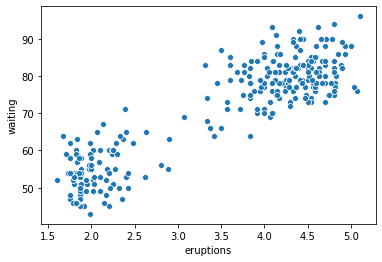

In [3]:
# Visualizing the dataset
sns.scatterplot('eruptions', 'waiting', data = tt)

There are 2 distinct clusters,let's set the no of clusters K=2 for the Gaussian Mixture Model

In [4]:
# Evaluate the initial value of the log likelihood
def bivariate_norm_density(obs, mu, sig):
    determ = np.linalg.det(sig)
    invsig = np.linalg.inv(sig)
    density = 1/((2*np.pi)*np.sqrt(determ))*np.exp(-0.5*np.matmul(np.matmul((obs-mu).T, invsig), (obs-mu)))
    return(density)
# Evaluate the initial value of the log likelihood
def bivariate_norm_loglik(obs, pi, mu1, sig1, mu2, sig2):
    lik = pi[0]*bivariate_norm_density(obs, mu1, sig1) + pi[1]*bivariate_norm_density(obs, mu2, sig2)
    loglik = np.log(lik)
    return(loglik)
#implement the Expectation Maximization (EM) algorithm for the Gaussian Mixture Model.
# specify the maximum number of iteration in case the algorithm does not converge
max_it = 1000
# split the data into two groups for initial value set up
X1 ,X2 = train_test_split(tt, test_size=0.5, random_state = 20200507)
# initialize the means by finding sample means from each randon split
means1 = np.mean(X1, axis = 0).values.T
means2 = np.mean(X2, axis = 0).values.T
# initialize the covariances by finding sample covariances from each randon split
cov1 = np.cov(X1.T)
cov2 = np.cov(X2.T)
# initialize the mixing coefficient by assigning equal split
mixing = np.ones(2)/2

# calculate log likelihood using the initial values
loglik_sum = np.zeros(len(tt))
for index in range(len(tt)):
    loglik_sum[index] = bivariate_norm_loglik(tt.values[index], mixing, means1, cov1, means2, cov2)
loglik = np.sum(loglik_sum)

# The E-M algorithm will loop until the convergence criterion is met or max iteration is reached
for iteration in range(max_it):
    # Calculate the density values for each cluster
    densities = np.zeros((len(tt),2))
    for index in range(len(tt)):
        densities[index, 0] = bivariate_norm_density(tt.values[index].T, means1, cov1)
        densities[index, 1] = bivariate_norm_density(tt.values[index].T, means2, cov2)
    # Evaluate the responsibilities using the current parameter estimates
    gama = np.zeros((len(tt),2))
    for index in range(len(tt)):
        gama[index, 0] = mixing[0]*densities[index, 0]/np.sum(mixing * densities[index, :])
        gama[index, 1] = mixing[1]*densities[index, 1]/np.sum(mixing * densities[index, :])
    # Calculate the N_k
    N_k = np.sum(gama, axis = 0)
    
    # Update mu1 and mu2
    means1_new_sum = np.zeros((len(tt),2))
    means2_new_sum = np.zeros((len(tt),2))
    for index in range(len(tt)):
        means1_new_sum[index, :] = gama[index,0] * tt.values[index]
        means2_new_sum[index, :] = gama[index,1] * tt.values[index]
    means1_new = np.sum(means1_new_sum, axis = 0)/N_k[0]
    means2_new = np.sum(means2_new_sum, axis = 0)/N_k[1]
    
    # Update cov1 and cov2
    sig1_new_sum = np.zeros((len(tt),3))
    sig2_new_sum = np.zeros((len(tt),3))
    for index in range(len(tt)):
        # (x_n - mu_k) part
        diff1 = tt.values[index] - means1_new
        diff2 = tt.values[index] - means2_new
        # this vector will be (sigma1, sigma2, rho)
        vec1 = np.array([diff1[0]*diff1[0],diff1[1]*diff1[1],diff1[0]*diff1[1]])
        vec2 = np.array([diff2[0]*diff2[0],diff2[1]*diff2[1],diff2[0]*diff2[1]])
        # calculate gama(z_nk) * (sigma1, sigma2, rho)
        sig1_new_sum[index, :] = gama[index,0] * vec1
        sig2_new_sum[index, :] = gama[index,1] * vec2
    # obtain the updated (sigma1, sigma2, rho)
    sig1_new = np.sum(sig1_new_sum, axis = 0)/N_k[0]
    sig2_new = np.sum(sig2_new_sum, axis = 0)/N_k[1]
    # convert it back to proper variance-covariance matrix form
    cov1_new = np.array([[sig1_new[0],sig1_new[2]],[sig1_new[2],sig1_new[1]]])
    cov2_new = np.array([[sig2_new[0],sig2_new[2]],[sig2_new[2],sig2_new[1]]])
    
    # update mixing coefficients
    mixing_new = N_k/len(tt)
    
    # replace old parameter estimates with the updated ones
    means1 = means1_new
    means2 = means2_new
    cov1 = cov1_new
    cov2 = cov2_new
    mixing = mixing_new
    
    # calculate the log likelihood using updated parameter estimates
    loglik_sum = np.zeros(len(tt))
    for index in range(len(tt)):
        loglik_sum[index] = bivariate_norm_loglik(tt.values[index], mixing, means1, cov1, means2, cov2)
    loglik_new = np.sum(loglik_sum)
    
    # the algorithm will be considered converged if the change in log likelihood is less than 10^-16.
    if(np.abs(loglik_new - loglik) < 10**(-16)):
        break
    
    # update the log-likelihood value
    loglik = loglik_new
    #We inspect the final parameter estimates of the Gaussian mixture model with two clusters.
print("mu1")
print(means1)
print("mu2")
print(means2)
print("Sigma1")
print(cov1)
print("Sigma2")
print(cov2)
print("pi")
print(mixing)
print("log likelihood")
print(loglik)

mu1
[ 2.03638845 54.47851638]
mu2
[ 4.28966197 79.96811518]
Sigma1
[[ 0.06916767  0.43516763]
 [ 0.43516763 33.69728209]]
Sigma2
[[ 0.16996844  0.94060931]
 [ 0.94060931 36.04621126]]
pi
[0.35587286 0.64412714]
log likelihood
-1130.2639601847416


In [5]:
#We cluster the old tt geyser data set using the estimated Gaussian Mixture model.
# calculate the density values
densities = np.zeros((len(tt),2))
for index in range(len(tt)):
    densities[index, 0] = bivariate_norm_density(tt.values[index].T, means1, cov1)
    densities[index, 1] = bivariate_norm_density(tt.values[index].T, means2, cov2)
# each observation will belong to the cluster with higher density value
clustered = np.argmax(densities, axis = 1)

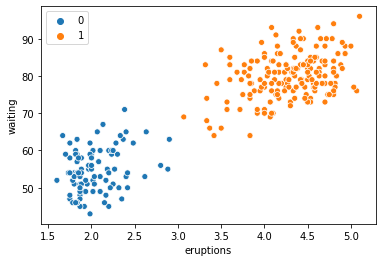

In [6]:
#We inspect how well the clustering was done.
sns.scatterplot('eruptions', 'waiting', hue = clustered, data = tt)

# Problem 2 (23 points)

**QUESTION**: Use with a dataset different from IRIS the following technique:

https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html (scikit)

Explain why this technique is important.

In [7]:
# read the data set
wine = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv',sep=';')
wine.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
5,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
6,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.9949,3.18,0.47,9.6,6
7,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
8,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
9,8.1,0.22,0.43,1.5,0.044,28.0,129.0,0.9938,3.22,0.45,11.0,6


In [8]:
#We will classify the wine as an 'OK' wine if its quality rating is at least 6.
wine.loc[wine['quality'] >= 6, 'OK'] = 1
wine.loc[wine['quality'] < 6, 'OK'] = 0
quality_ratings = wine['quality']
wine.drop('quality', 1, inplace = True)
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,OK
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,1.0
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,1.0
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1.0
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1.0
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1.0


In [9]:
#Adding some dummy variables and save feature names for later use
dummy_variable = np.random.random_sample(len(wine))
wine.insert(0, 'dummy', dummy_variable)


Feature ranking:
Rank 1. alcohol (importance: 0.158760)
Rank 2. volatile acidity (importance: 0.106541)
Rank 3. density (importance: 0.090954)
Rank 4. free sulfur dioxide (importance: 0.084875)
Rank 5. citric acid (importance: 0.079378)
Rank 6. total sulfur dioxide (importance: 0.079113)
Rank 7. chlorides (importance: 0.075494)
Rank 8. residual sugar (importance: 0.074192)
Rank 9. pH (importance: 0.070770)
Rank 10. fixed acidity (importance: 0.068619)
Rank 11. sulphates (importance: 0.066064)
Rank 12. dummy (importance: 0.045239)


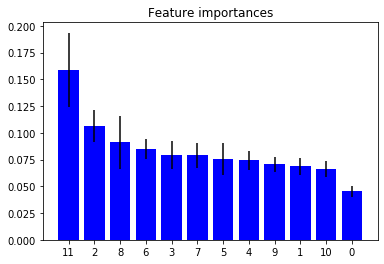

In [10]:
num_features = 11 + 1
feature_names = wine.columns[0:num_features]
#Splitting dataset into independent features (x) and dependent feature (y).
x_wine = wine.values[:,0:num_features]
y_wine = wine.values[:,num_features]
#Normalize the data set so that the mean = 0 and standard deviation = 1
scaler = StandardScaler()
x_wine = scaler.fit_transform(x_wine)
#Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250, random_state=0)
forest.fit(x_wine, y_wine)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices_fi = np.argsort(importances)[::-1]
#Print the feature ranking and plot the feature importances of the forest.
# Print the feature ranking
print("Feature ranking:")
for f in range(x_wine.shape[1]):
    print("Rank %d. %s (importance: %f)" % (f + 1, feature_names[indices_fi[f]], importances[indices_fi[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_wine.shape[1]), importances[indices_fi], color="b", yerr=std[indices_fi], align="center")
plt.xticks(range(x_wine.shape[1]), indices_fi)
plt.xlim([-1, x_wine.shape[1]])
plt.show()

## Explanation: why it is important
From the results, we can observe that the feature "alcohol" is the most significant feature in classifying this wine quality data set.Expectedly, the dummy variable was determined to be the least significant feature.

This method makes us to see which of the features are more useful than the others in solving classification problems. This can be particularly useful when we are working with the dataset that has a lot of features and only some of them are useful.

# Problem 3 (23 points)

**QUESTION**: Compare by discussing results the technique in 2 with the coefficients (W) of the logistic regression. (scikit)

In [11]:
lm = LogisticRegression(penalty='l2',C=0.1, solver = 'liblinear')
lm.fit(x_wine, y_wine)
coefficients = lm.coef_[0]
coefficients

array([-0.00350486, -0.01859187, -0.63536982,  0.01286768,  0.69249198,
        0.00334289,  0.17004172, -0.07214299, -0.56992915,  0.12189174,
        0.18785088,  0.9819372 ])

Feature ranking:
Rank 1. alcohol (coefficient: 0.981937)
Rank 2. residual sugar (coefficient: 0.692492)
Rank 3. volatile acidity (coefficient: -0.635370)
Rank 4. density (coefficient: -0.569929)
Rank 5. sulphates (coefficient: 0.187851)
Rank 6. free sulfur dioxide (coefficient: 0.170042)
Rank 7. pH (coefficient: 0.121892)
Rank 8. total sulfur dioxide (coefficient: -0.072143)
Rank 9. fixed acidity (coefficient: -0.018592)
Rank 10. citric acid (coefficient: 0.012868)
Rank 11. dummy (coefficient: -0.003505)
Rank 12. chlorides (coefficient: 0.003343)


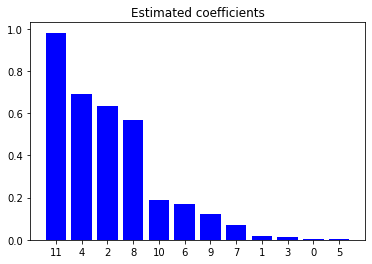

In [12]:
#Build a forest and compute the feature importances
indices_lm = np.argsort(np.abs(coefficients))[::-1]
#Print the feature ranking and plot the feature importances of the forest.
# Print the feature ranking
print("Feature ranking:")
for f in range(x_wine.shape[1]):
    print("Rank %d. %s (coefficient: %f)" % (f + 1, feature_names[indices_lm[f]], coefficients[indices_lm[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Estimated coefficients")
plt.bar(range(x_wine.shape[1]), np.abs(coefficients[indices_lm]), color="b", align="center")
plt.xticks(range(x_wine.shape[1]), indices_lm)
plt.xlim([-1, x_wine.shape[1]])
plt.show()

In summary, we can see that the features with high importance end up with larger estimated coefficients, although the ranking is not strictly the same. This finding is not surprising because feature importance and logistic regression estimated coefficients measure two distinctive things. Feature importance measures the mean decrease in impurity for random forest models. Meaning that, feature importance measures the amount of uncertainty in the dependent feature when training a random forest model, and logistic regression estimated coefficients directly measure the amount of contribution to the estimated log odds of the dependent feature for a unit increase in a particular independent feature. Sure, if a certain feature is particularly useful in classifying the certain data set, it would reduce the uncertainty  in the label when training a random forest model (hence the larger feature importance value) and it would also likely have a larger coefficient estimate for the logistic regression model (since it is useful, it should likely contribute more to the log odds). However, it won't necessarily be the case. For e.g, if a certain feature has a wide range of possible values ( 1 through 100), then its coefficient estimate for the logistic regression model won't be that large even if the feature may be the perfect regressor.

# Problem 4 (12 points)

**QUESTION**: Describe the main differences between K-means and DB-Scan, use examples. (scikit)

In [13]:
#We will generate isotropic Gaussian blobs using the "make_blobs" function.
X_sim, y_sim = make_blobs(n_samples=600, centers=5, n_features=2, random_state=20220506)
#Saving the generated data set as Pandas DataFrame object.
sim_data = pd.DataFrame(X_sim, columns=['V1', 'V2'])
sim_data.head()

,V1,V2
0,-6.383001,-6.674163
1,-5.624838,-3.585021
2,10.102209,-8.419450
3,2.174971,-0.665597
4,8.914314,-8.238335


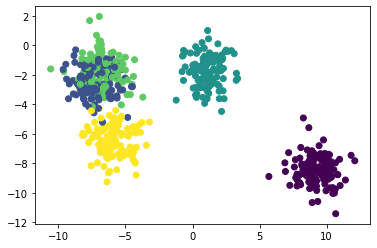

In [14]:
#Since it is bivariate data set, we can visualize the data set using the scatterplot.
plt.scatter(X_sim[:,0], X_sim[:,1], c = y_sim)

We can see that although we intended to have six clusters, there are four distinct clusters.
Here, we will compare DBscan and K-means clustering by presenting a few main differences.
DBscan does not require the user to set the number of clusters whereas K-means does.
DBscan is able to detect outliers (if exists) whereas K-means does not.

### DBSCan

We implement the DBscan algorithm to cluster iris data set. Other than the the radius of a neighborhood (epsilon), we will leave the rest of hyperparameters to default.


In [15]:
#note that the user does not need to set the number of clusters, rather the user needs to set the radius of a neighborhood.
DBscan_model = DBSCAN(eps=1)
DBscan_model.fit(X_sim)


DBSCAN(algorithm='auto', eps=1, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

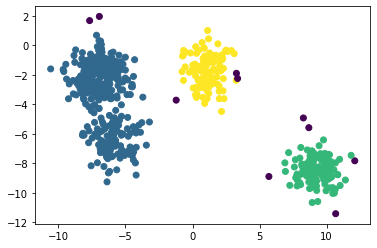

In [16]:
plt.scatter(X_sim[:,0], X_sim[:,1], c = DBscan_model.labels_)

We see some points (black) are determined to not belong to any cluster. Looking at the labels, we can see these nine points since the points without a cluster is denoted as '-1'.

In [17]:
DBscan_model.labels_

array([ 0,  0,  1,  2,  1,  0,  0,  1,  1,  2,  0,  0,  2,  0,  1,  2,  2,
        1,  0,  1,  0,  0,  0,  2,  1,  1,  1,  0,  2,  2,  2,  1,  1,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  1,  0,  2,  0,  0,  1,  0,
        2,  0,  0,  0,  0,  2,  2,  0,  2,  0,  0,  2,  0,  1,  0,  0,  1,
        0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  1,  0,  0,  0,
        0,  0,  0,  0,  2,  0,  0,  2,  0,  1,  0,  2,  0,  0,  0,  0,  0,
        0,  1,  1,  0,  1,  0,  0,  0,  0,  0,  1,  1,  1,  2,  1,  0,  0,
        0,  0,  0,  0,  1,  0,  1,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  2,  0,  2,  2,  1,  0, -1,  1,  1,  0,  0,  0,  0,  1,  0,  0,
        2,  0,  0,  1,  1,  0,  2,  0,  0,  0,  0,  0,  2,  1,  0,  0,  0,
        0,  0,  1,  2,  1,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,
        2,  0,  0,  0,  1,  0,  2,  0,  0,  0,  0,  0,  1,  2,  2,  1,  1,
        0,  2,  0,  2,  0,  2,  0,  0,  0,  0,  0,  0,  2,  2,  0,  2,  0,
        0,  0,  2,  0,  0

Although DBscan was able to successfully determine that there are three clusters in the data set, it was unable to cluster the nine points and they were determined as 'outliers'. Conversely,if we increase the radius of a neighborhood appropriately, we notice that all points now belong to one cluster and DBscan was able to successfully determine that there are three clusters in the data set.

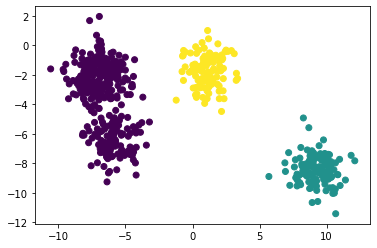

In [18]:
DBscan_model = DBSCAN(eps=1.5, min_samples=1, leaf_size=10)
DBscan_model.fit(X_sim)
plt.scatter(X_sim[:,0], X_sim[:,1], c = DBscan_model.labels_)

### K-means
K-means clustering requires the user to specify the number of clusters. Wrong choice of K can lead to inappropriate clusterings. However, we can notice that all points belong to one cluster no matter what (unlike DBscan).

In [19]:
Kmeans_model = KMeans(n_clusters=2, random_state=20220506)
Kmeans_model.fit(X_sim)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=20220506, tol=0.0001, verbose=0)

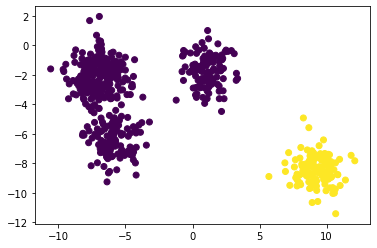

In [20]:
plt.scatter(X_sim[:,0], X_sim[:,1], c = Kmeans_model.labels_)

In [21]:
Kmeans_model = KMeans(n_clusters=10, random_state=20200427)
Kmeans_model.fit(X_sim)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=20200427, tol=0.0001, verbose=0)

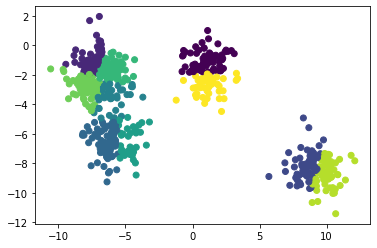

In [22]:
plt.scatter(X_sim[:,0], X_sim[:,1], c = Kmeans_model.labels_)

If the user correctly specifies the number clusters, the K-means clustering successfully determine that there are three clusters in the data set.

In [23]:
Kmeans_model = KMeans(n_clusters=3, random_state=20200427)
Kmeans_model.fit(X_sim)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=20200427, tol=0.0001, verbose=0)

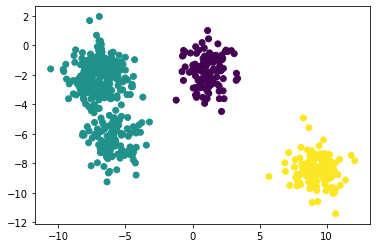

In [24]:
plt.scatter(X_sim[:,0], X_sim[:,1], c = Kmeans_model.labels_)

# Problem 5 (24 points)

**QUESTION**: Implement a procedure to estimate the optimal number of clusters in the k-Means and Gaussian mixture model (try to differentiate the two procedures). (scikit)

In [25]:
#We will generate isotropic Gaussian blobs using the "make_blobs" function.
X_sim, y_sim = make_blobs(n_samples=500, centers=5, n_features=2, random_state=20220506)
#Save the generated data set as Pandas DataFrame object.
sim_data = pd.DataFrame(X_sim, columns=['V1', 'V2'])
sim_data.head()

,V1,V2
0,1.302661,-3.693718
1,-6.784595,-0.248729
2,-8.091585,-6.100636
3,-6.821019,-1.546819
4,-6.359071,-2.266158


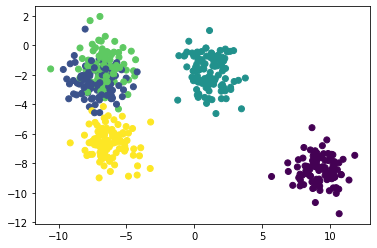

In [26]:
#Since it is bivariate data set, we can visualize the data set using the scatterplot.
plt.scatter(X_sim[:,0], X_sim[:,1], c = y_sim)

We can see that although we intended to have five clusters, there are four distinct clusters. We expect K = 4 to be determined the most optimal cluster size.

### K-means Clustering
To find the optimal number of clusters in the K-means clustering, we will be using the silhouette coefficient. The number of clusters that yields the highest silhouette coefficient would be considered the optimal number of clusters.

K-means clustering
K = 2. Silhouette Coefficient = 0.680048
K = 3. Silhouette Coefficient = 0.684956
K = 4. Silhouette Coefficient = 0.677728
K = 5. Silhouette Coefficient = 0.562463
K = 6. Silhouette Coefficient = 0.559197
K = 7. Silhouette Coefficient = 0.478981
K = 8. Silhouette Coefficient = 0.385975
K = 9. Silhouette Coefficient = 0.345447
K = 10. Silhouette Coefficient = 0.338047


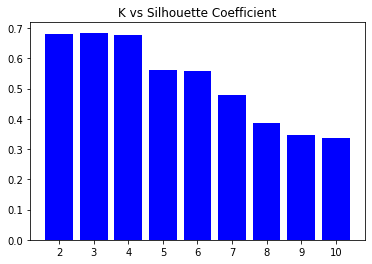

In [27]:
cluster_sizes = [2,3,4,5,6,7,8,9,10]
#Fit the K-means clustering model for each cluster size under consideration and calculate the silhouette coefficient.
sil_score = np.zeros(len(cluster_sizes))
for K in range(len(cluster_sizes)):
    Kmeans_model = KMeans(n_clusters=cluster_sizes[K], random_state=20200507)
    Kmeans_model.fit(sim_data)
    sil_score[K] = silhouette_score(sim_data, Kmeans_model.labels_)
    # Print the feature ranking
    #Visualize the number of clusters vs silhouette coefficient.
print("K-means clustering")
for f in range(len(cluster_sizes)):
        print("K = %d. Silhouette Coefficient = %f" % (cluster_sizes[f], sil_score[f]))

# Plot the feature importances of the forest
plt.figure()
plt.title("K vs Silhouette Coefficient")
plt.bar(range(len(cluster_sizes)), sil_score, color="b", align="center")
plt.xticks(range(len(cluster_sizes)), cluster_sizes)
plt.show()

It looks like K = 3 have the highest silhouette coefficient. We determine that K = 3 as the optimal number of clusters for this situation.


### Gaussian Mixture Models(GMMs)

In [28]:
#Specify the range of cluster sizes to consider
cluster_sizes = [1,2,3,4,5,6,7,8,9,10]

Fit the Gaussian mixture model for each cluster size under consideration and calculate the Bayesian information criterion which is defined as

$$BIC = k \ln (n) - 2 \ln (\hat{L})$$

where $k$ = number of parameters estimated by the model, $n$ = number of observations, and $\hat{L}$ is the optimized log likelihood value of the model. The model with the lowest BIC is to be preferred.

Gaussian Mixture Models
K = 1. BIC = 5635.310821
K = 2. BIC = 4993.162115
K = 3. BIC = 4456.263987
K = 4. BIC = 4373.559720
K = 5. BIC = 4430.465008
K = 6. BIC = 4495.819256
K = 7. BIC = 4581.228378
K = 8. BIC = 4673.997208
K = 9. BIC = 4775.214859
K = 10. BIC = 4888.406170


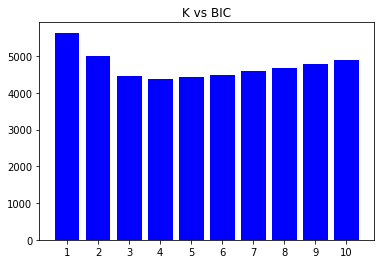

In [29]:
#Fit the GMM model for each cluster size under consideration and calculate the BIC.
BIC = np.zeros(len(cluster_sizes))
for K in range(len(cluster_sizes)):
    GMM = GaussianMixture(n_components=cluster_sizes[K], random_state=20200507)
    GMM.fit(sim_data)
    k = cluster_sizes[K]
    if K == 1:
        # With 1 cluster, there are one mean and one variance.
        num_coefs = 2
    else:
        # With K clusters, there are K means, K mixing coefficients, K(K-1) variance/covariances.
        num_coefs = 2*cluster_sizes[K] + cluster_sizes[K]*(cluster_sizes[K] - 1)
    BIC[K] = num_coefs*np.log(len(sim_data)) - 2*GMM.score(sim_data)*len(sim_data)
    #Visualize the number of clusters vs BIC.
 # Print the feature ranking
print("Gaussian Mixture Models")
for f in range(len(cluster_sizes)):
    print("K = %d. BIC = %f" % (cluster_sizes[f], BIC[f]))

# Plot the feature importances of the forest
plt.figure()
plt.title("K vs BIC")
plt.bar(range(len(cluster_sizes)), BIC, color="b", align="center")
plt.xticks(range(len(cluster_sizes)), cluster_sizes)
plt.show()   

The graph is a bit hard to read. We will see which cluster size yielded the lowest BIC.

In [30]:
cluster_sizes[np.argmin(BIC)]

4

It looks like K = 4 has the lowest BIC, as expected. We determine that K = 4 as the optimal number of clusters for this situation as well.

# Problem 6 (24 points)

**QUESTION**: Implement the algorithm of hierarchical clustering with maximum or complete linkage 

(this can help www.econ.upf.edu/~michael/stanford/maeb7.pdf)

<Figure size 360x360 with 0 Axes>

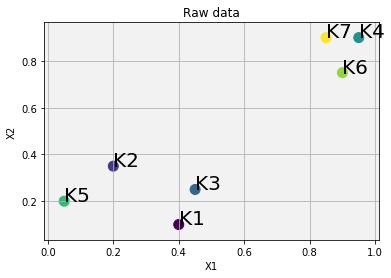


*****************************************
... Agglomeration step:  1
New clustering:  ['K1', 'K2', 'K3', '(K4K7)', 'K5', 'K6']

Dissimilarities: 
[[0.   0.32 0.16 0.97 0.36 0.82]
 [0.32 0.   0.27 0.93 0.21 0.81]
 [0.16 0.27 0.   0.82 0.4  0.67]
 [0.97 0.93 0.82 0.   1.14 0.16]
 [0.36 0.21 0.4  1.14 0.   1.01]
 [0.82 0.81 0.67 0.16 1.01 0.  ]]

*****************************************
... Agglomeration step:  2
New clustering:  ['(K1K3)', 'K2', '(K4K7)', 'K5', 'K6']

Dissimilarities: 
[[0.   0.32 0.97 0.4  0.82]
 [0.32 0.   0.93 0.21 0.81]
 [0.97 0.93 0.   1.14 0.16]
 [0.36 0.21 1.14 0.   1.01]
 [0.82 0.81 0.16 1.01 0.  ]]

*****************************************
... Agglomeration step:  3
New clustering:  ['(K1K3)', 'K2', '((K4K7)K6)', 'K5']

Dissimilarities: 
[[0.   0.32 0.97 0.4 ]
 [0.32 0.   0.93 0.21]
 [0.97 0.93 0.   1.14]
 [0.36 0.21 1.14 0.  ]]

*****************************************
... Agglomeration step:  4
New clustering:  ['(K1K3)', '(K2K5)', '((K4K7)K6)']

Dissimila

In [31]:


verbose = 0

#Assuming a simple 2D dataset, to enable visualization
X = [[0.4,0.1],[0.2,0.35],[0.45,0.25],[0.95,0.9],[0.05,0.2],[0.9,0.75],[0.85,0.9]]
X = np.asarray(X)
#print(X.shape)

Y = [0,1,2,3,4,5,6]
Y = np.asarray(Y)
#print(Y.shape)

#sample names
grp = ["K1","K2","K3","K4","K5","K6","K7"]
n_Sampls = X.shape[0]

#Visualize datapoints
plt.figure(figsize=(5,5))
fig,ax = plt.subplots()
ax.set_facecolor((0.95,0.95,0.95))
ax.scatter(X[:, 0], X[:, 1], c=Y, s=100)
for i,txt in enumerate(grp):
    ax.annotate(txt, (X[i,0], X[i,1]),fontsize=20, color='k')
strTitle = "Raw data"
plt.title(strTitle)
plt.xlabel("X1")
plt.ylabel("X2")
plt.grid(True)
plt.show()

sim_Matrx = np.zeros(shape=(n_Sampls,n_Sampls))
maskMatrix = np.zeros(shape=(n_Sampls,n_Sampls))

for i in range(n_Sampls):
    for j in range(n_Sampls):
        sim_Matrx[i][j]=np.round(spatial.distance.euclidean(X[i,:],X[j,:]),2)
        if i==j:
            maskMatrix[i][j]=1

solve = True
string=""

ct = 1
while solve==True:  #Solve until heirarchy is built completely
    a = np.unravel_index(np.argmin(np.add(sim_Matrx,maskMatrix)),sim_Matrx.shape)
    print("\n*****************************************")
    print("... Agglomeration step: ",ct)
    newgroup = "("+grp[a[0]]+grp[a[1]]+")"
    if verbose:
        print(newgroup,type(newgroup))

    #Maximum linkage or Complete linkage
    rowMax = np.maximum(sim_Matrx[a[0]][:],sim_Matrx[a[1]][:])
    colMax = np.maximum(sim_Matrx[:][a[0]],sim_Matrx[:][a[1]])
    if verbose:
        print(rowMax)
        print(colMax)

    sim_Matrx[a[0]][:] = rowMax
    sim_Matrx[a[1]][:] = rowMax
    sim_Matrx[:][a[0]] = colMax
    sim_Matrx[:][a[1]] = colMax

    grp[int(a[0])] = newgroup
    #print(grp)

    del grp[a[1]]
    n_Sampls = len(grp)
    print("New clustering: ",grp)

    sim_Matrx=np.delete(sim_Matrx,a[1],0)
    sim_Matrx=np.delete(sim_Matrx,a[1],1)
    maskMatrix=np.delete(maskMatrix,a[1],0)
    maskMatrix=np.delete(maskMatrix,a[1],1)

    for m in range(n_Sampls):
        for n in range(n_Sampls):
            if m==n:
                sim_Matrx[m][n]=0.0
    print("\nDissimilarities: ")
    print(sim_Matrx)

    ct = ct+1

    if n_Sampls==2:
        grp = "("+grp[0]+grp[1]+")"
        print("\n\n******************************************")
        print("FINAL RESULT:\n>>> Hierarchical Clustering: ",grp)
        solve=False #Terminates agglomeration

